In [237]:
#import needed libs
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
import calendar

#Method to parse json like genre string and return csv string
def extractGenres(string):
    try:
        x = string.replace("'", '"')
        jsonStr = json.loads(x)
        genres = ""
        for item in jsonStr:
            for key in item:
                if (key == 'name'):
                    genres += item[key] + ','
        return genres[0:(len(genres) - 1)]
    except:
        return ""
    
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

#Returns the month from input string
def returnMonth(string):
    try:
        return calendar.month_name[datetime.strptime((string), '%d/%m/%Y').month]
    except:
        return np.nan
    
#Returns the month from input string
def returnYear(string):
    try:
        return datetime.strptime((string), '%d/%m/%Y').year
    except:
        return np.nan

In [238]:
#read in movies data
movies = pd.read_csv("Z:/BDA Datasets/Movies/movies_metadata.csv")
#movies = movies[]

#Remove all rows where revenue is 0 or nan
movies = movies[movies['revenue'] != 0]
movies = movies[movies['revenue'] != '0']
movies = movies.dropna(subset=['revenue'])
movies = movies[movies['budget'] != 0]
movies = movies[movies['budget'] != '0']
movies = movies.dropna(subset=['budget'])
#Remove all rows where genre is 0 or nan
movies = movies[movies['genres'] != 0]
movies = movies[movies['genres'] != '0']
movies = movies.dropna(subset=['genres'])

#create a new column where csv goes
movies['genre'] = ""
movies['genre'] = movies['genres'].apply(lambda x: extractGenres(x))
#Remove invalid rows
movies = movies[movies['genre'] != '']
movies['genre'] = movies['genre'].str.split(',')
movies = explode(movies, ['genre'])

In [239]:
movies['releasemonth'] = movies['release_date'].apply(lambda x: returnMonth(x)) 
movies['releaseyear'] = movies['release_date'].apply(lambda x: returnYear(x)) 
movies = movies[movies['genre'] != "TV Movie"]

movies = movies[movies['releaseyear'] > 1990]

movies = movies[movies['vote_average'] != 0]



[Text(114.0, 0.5, 'Year of Release'),
 Text(0.5, 51.0, 'Movie Genre'),
 Text(0.5, 1, 'Movie Revenue')]

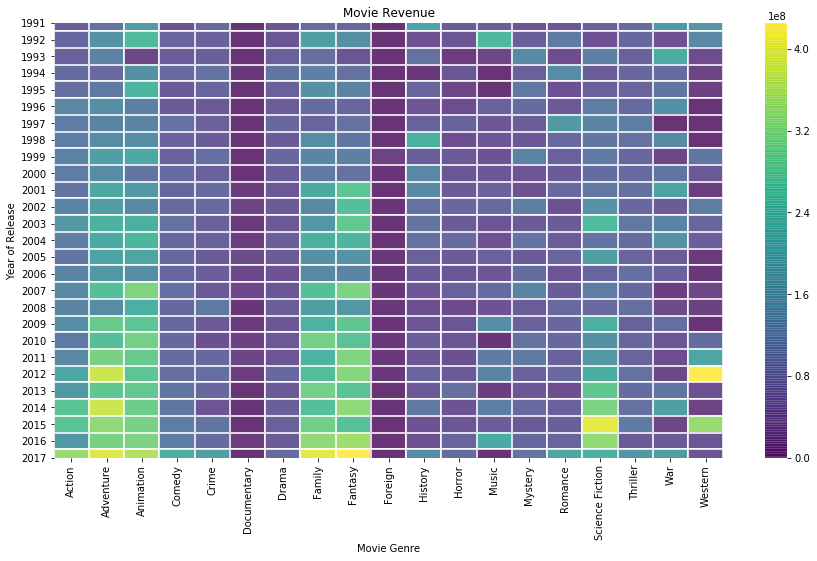

In [241]:
#setting up the plot
fig, ax = plt.subplots(figsize=(15,8))
kwargs = {'alpha':0.8,'linewidth':1, 'linestyle':'--',  "capstyle":'projecting'}
#used to make sure months columns are in correct order!
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#movies['revenue'] = (movies['revenue'] - movies['revenue'])
pivot = movies.pivot_table(index='releaseyear', columns='genre', values='revenue',fill_value=0)
#pivot = pivot.reindex(months)
#pivot = pd.pivot_table(data=movies,
#                    index='releasemonth',
#                    values='revenue',
#                    columns='genres')
sns.heatmap(pivot, **kwargs, cmap='viridis', ax=ax)
ax.set(xlabel='Movie Genre', ylabel='Year of Release',title='Movie Revenue')
